# Importing the necessary libraries

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Vectorizing the .png images

In [4]:
# Vectorize image function
def vectorize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    vectorized_contour = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vectorized_contour.append(approx)
    
    return vectorized_contour

# Save vectorized images function
def save_vectorized_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)
        vectorized_contour = vectorize_image(image_path)
        
        output_path = os.path.join(output_folder, filename.replace('.png', '.npy'))
        np.save(output_path, vectorized_contour)

# Preprocessing the data

In [6]:
# Load vectorized data function
def load_vectorized_data(base_dir, shape):
    vectorized_folder = os.path.join(base_dir, f'vectorized_{shape}_images')
    data = []
    labels = []
    
    for filename in os.listdir(vectorized_folder):
        vectorized_contour = np.load(os.path.join(vectorized_folder, filename), allow_pickle=True)
        flattened_contour = np.array([point.flatten() for contour in vectorized_contour for point in contour])
        data.append(flattened_contour)
        
        if shape == 'circle':
            labels.append([1, 0, 0, 0])
        elif shape == 'square':
            labels.append([0, 1, 0, 0])
        elif shape == 'triangle':
            labels.append([0, 0, 1, 0])
        elif shape == 'ellipse':
            labels.append([0, 0, 0, 1])
    
    return data, labels

# Define base directory and vectorize shapes
base_dir = 'F:\\Adobe-GenSolve\\Dataset'
shapes = ['circle', 'square', 'triangle', 'ellipse']
for shape in shapes:
    input_folder = os.path.join(base_dir, shape)
    output_folder = os.path.join(base_dir, f'vectorized_{shape}_images')
    save_vectorized_images(input_folder, output_folder)

# Load data for each shape
X_circle, y_circle = load_vectorized_data(base_dir, 'circle')
X_square, y_square = load_vectorized_data(base_dir, 'square')
X_triangle, y_triangle = load_vectorized_data(base_dir, 'triangle')
X_ellipse, y_ellipse = load_vectorized_data(base_dir, 'ellipse')

# Combine the data and labels
X = X_circle + X_square + X_triangle + X_ellipse
y = y_circle + y_square + y_triangle + y_ellipse

# Pad sequences to ensure uniform input size
max_len = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')

# Convert lists to numpy arrays
X_padded = np.array(X_padded)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5000, 10, 2)
y_train shape: (5000, 4)
X_test shape: (1251, 10, 2)
y_test shape: (1251, 4)


# Building the CNN Architecture which trains on the vectorized images and then regularize them

In [8]:
# Build CNN model function
def build_cnn_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(4, activation='softmax'))  # 4 output classes: Circle, Square, Triangle, Ellipse
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Build CNN model
cnn_model = build_cnn_model(input_shape)

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7729 - loss: 3.4608 - val_accuracy: 0.9145 - val_loss: 1.2410
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9176 - loss: 1.1853 - val_accuracy: 0.9153 - val_loss: 1.0041
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9280 - loss: 0.9641 - val_accuracy: 0.9241 - val_loss: 0.8508
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9435 - loss: 0.7906 - val_accuracy: 0.9744 - val_loss: 0.6631
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9522 - loss: 0.6704 - val_accuracy: 0.9608 - val_loss: 0.5753
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9566 - loss: 0.5738 - val_accuracy: 0.9824 - val_loss: 0.4745
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9756 - loss: 0.4674 - val_accuracy: 0.9792 - val_loss: 0.4021
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9788 - loss: 0.4000 - val_accuracy: 0.

# Converting the .png images into polylines for testing

In [23]:
import cv2
import numpy as np
import os

input_dir = 'F://Adobe-GenSolve//Dataset//Testing//Hand-Drawn-Shapes'
output_dir = 'F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Unable to load image at {image_path}")
            continue

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply binary thresholding
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty image to draw contours
        contour_image = np.zeros_like(image)

        # Draw contours as polylines
        for contour in contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            cv2.drawContours(contour_image, [approx], 0, (0, 255, 0), 2)

        # Save the resulting image
        output_path = os.path.join(output_dir, f'polylines_{filename}')
        cv2.imwrite(output_path, contour_image)
        print(f"Processed and saved: {output_path}")

Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-05-825_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-17-298_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-24-766_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-35-860_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-44-071_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\polylines_Screenshot_2024-08-10-13-22-52-526_com.miui.gallery.png
Processed and saved: F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes\po

# Predicting the possible shapes with the greatest probability

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


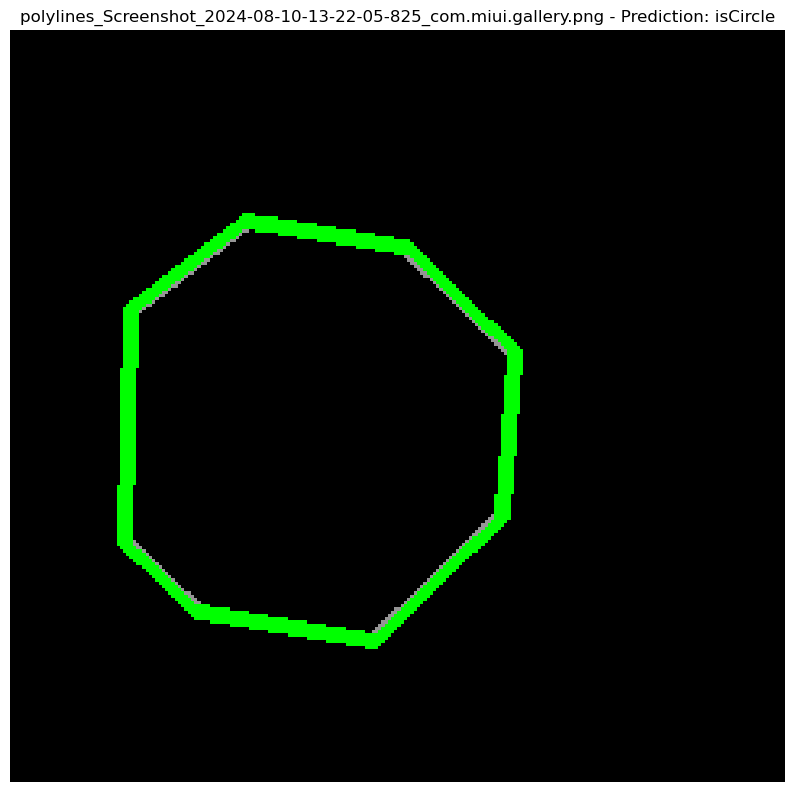

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


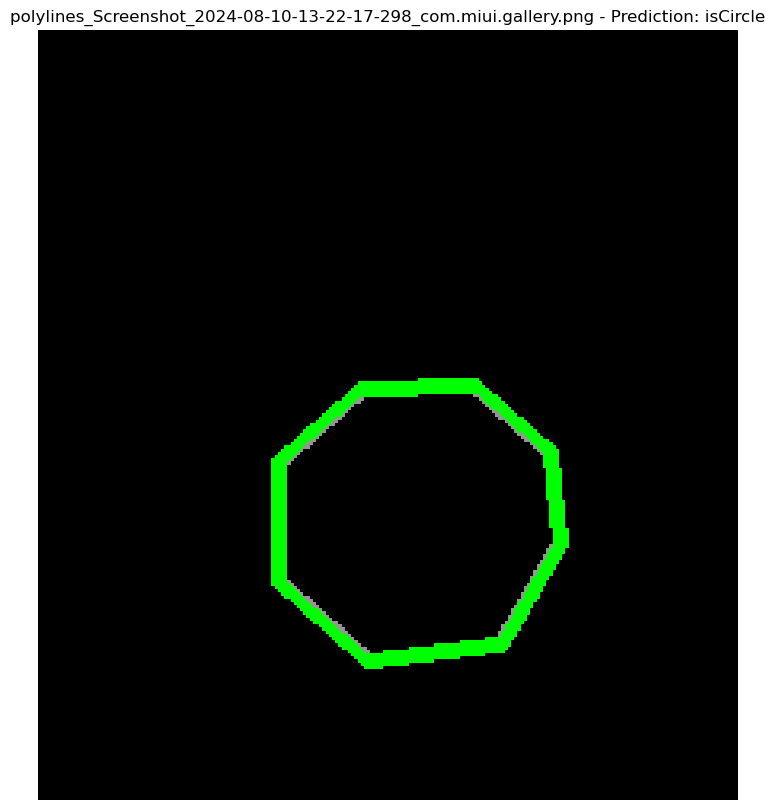

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


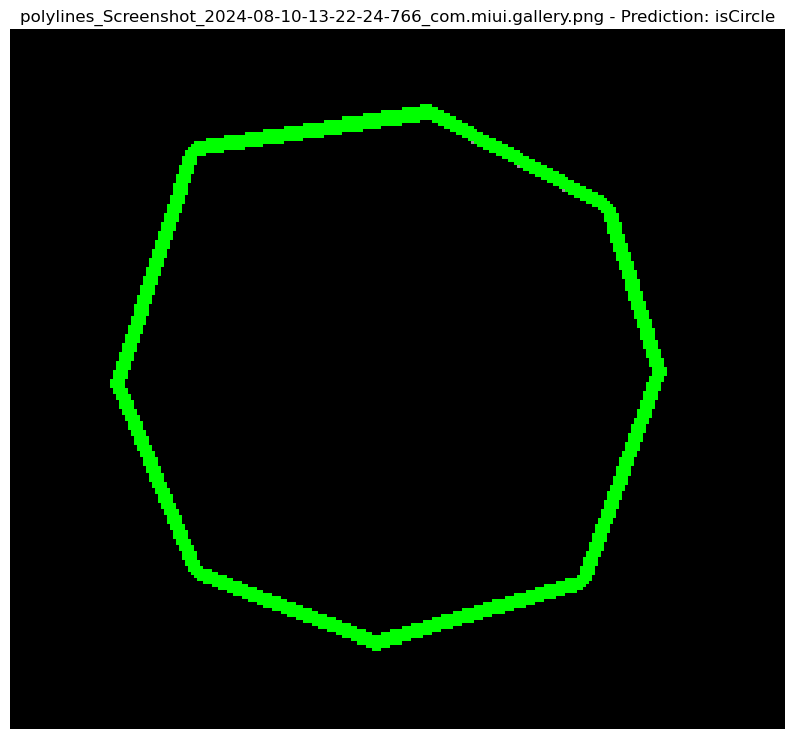

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


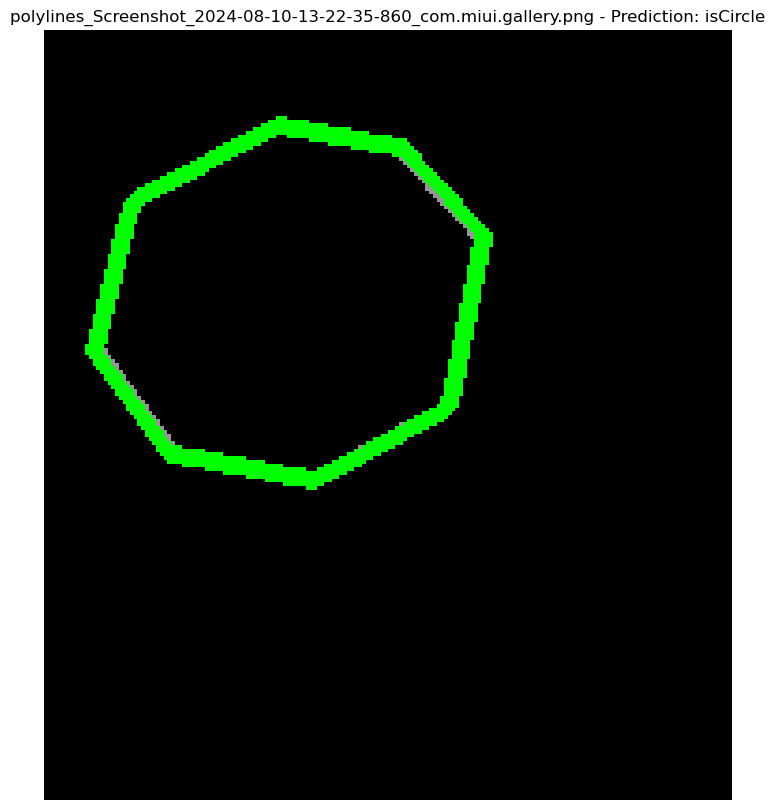

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


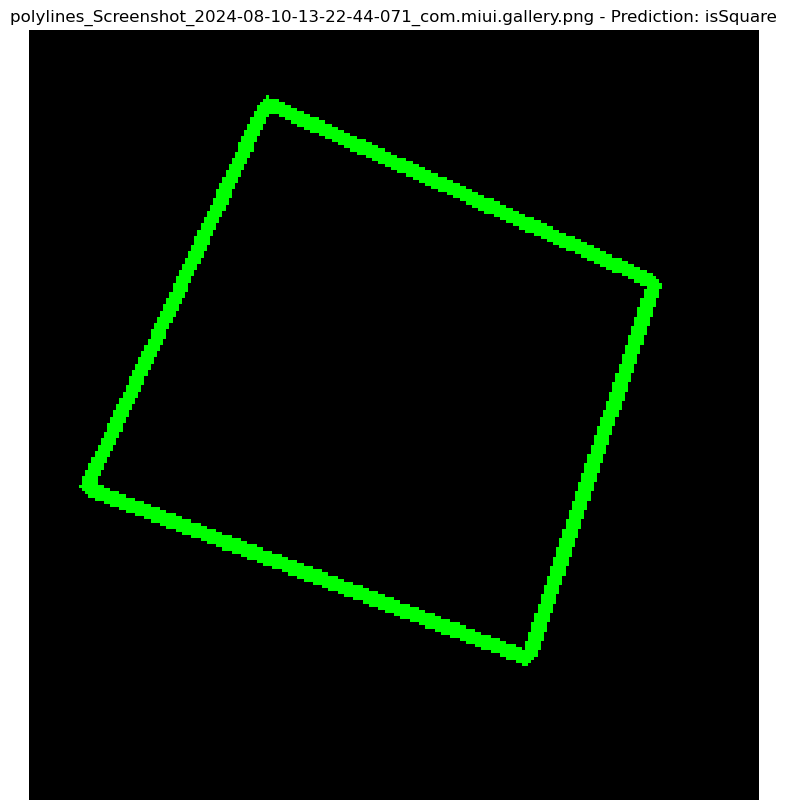

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


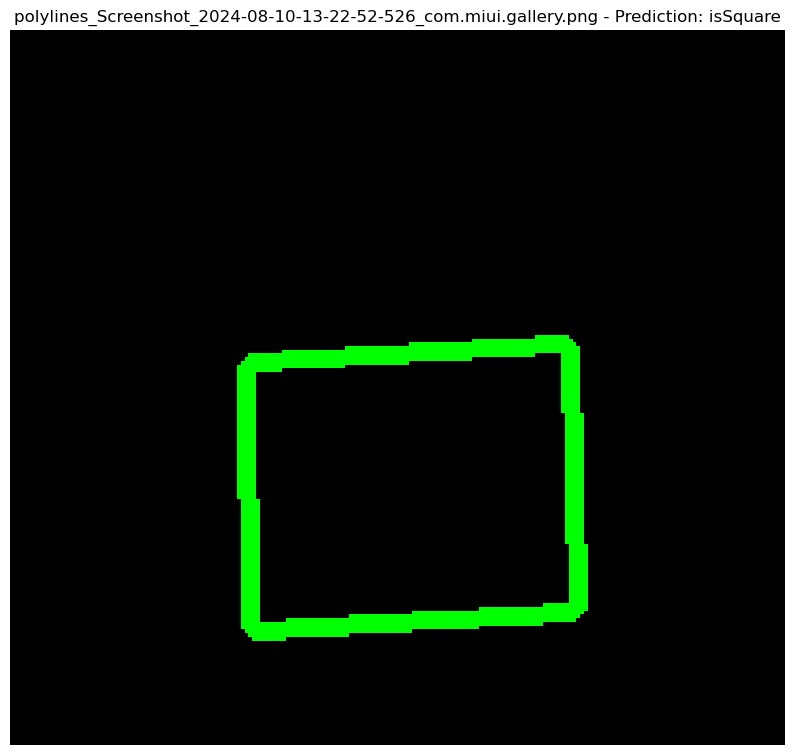

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


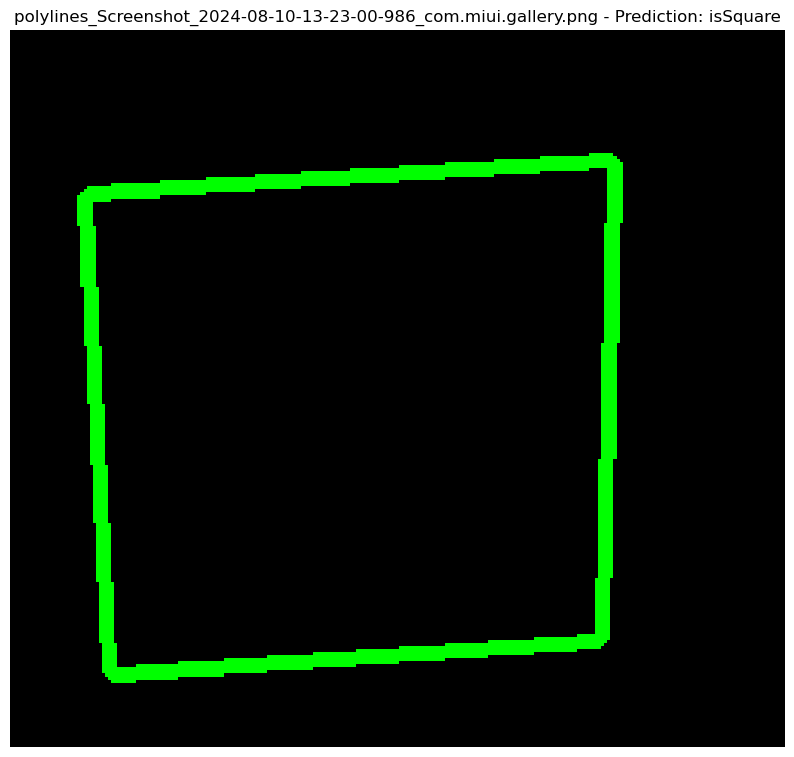

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


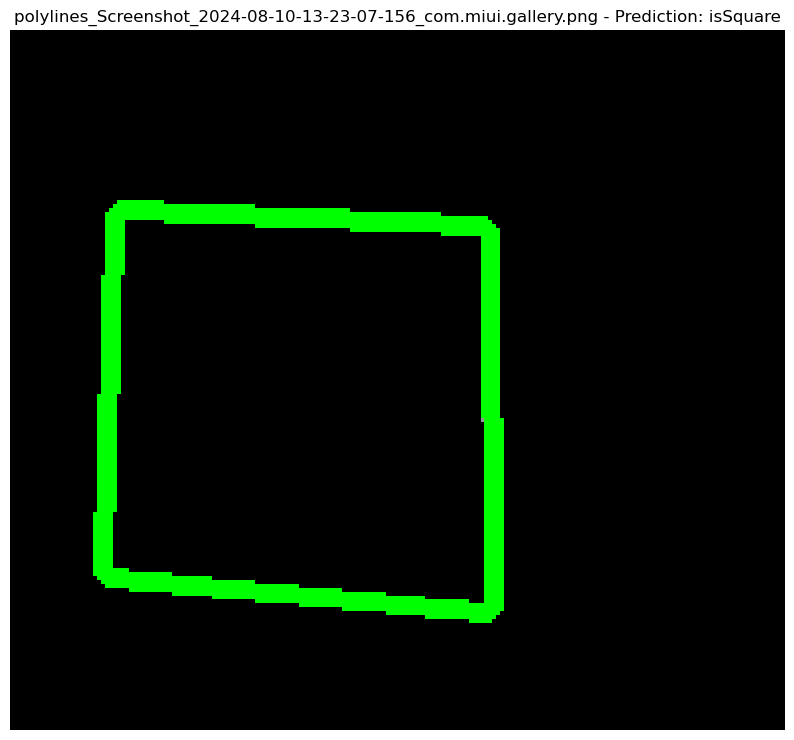

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


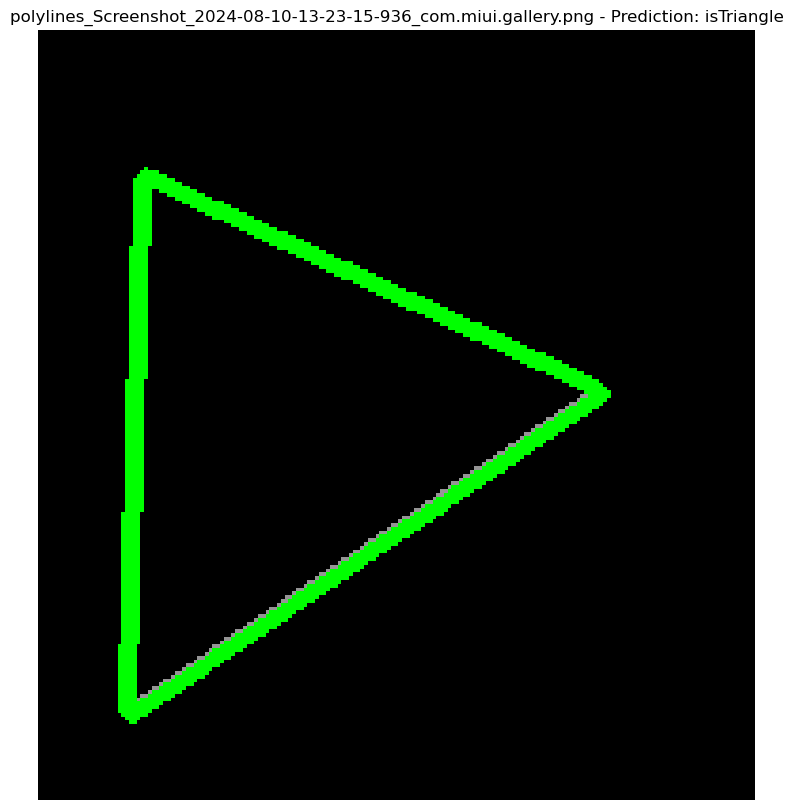

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


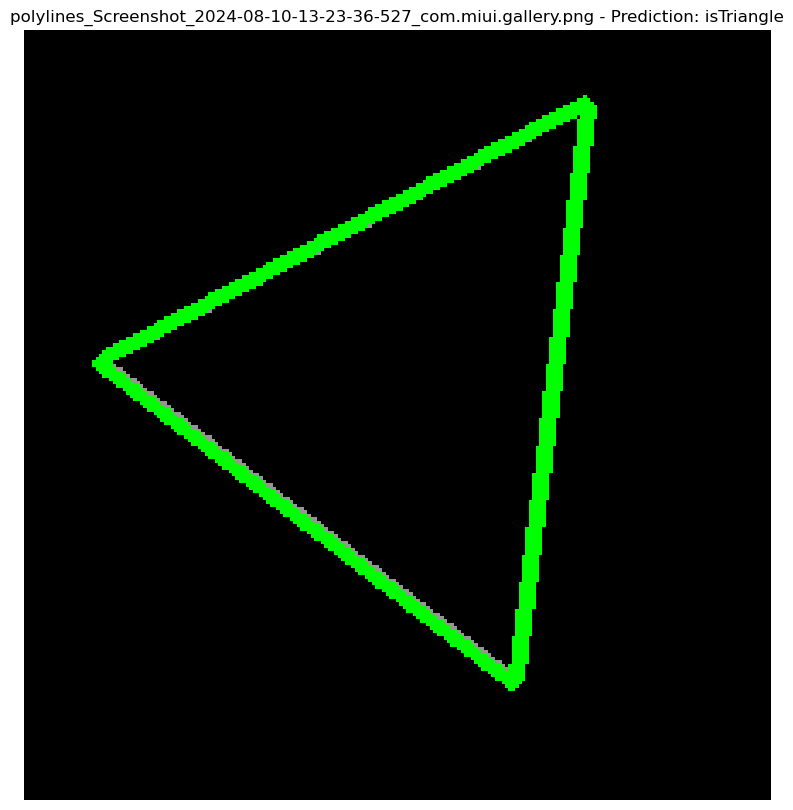

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


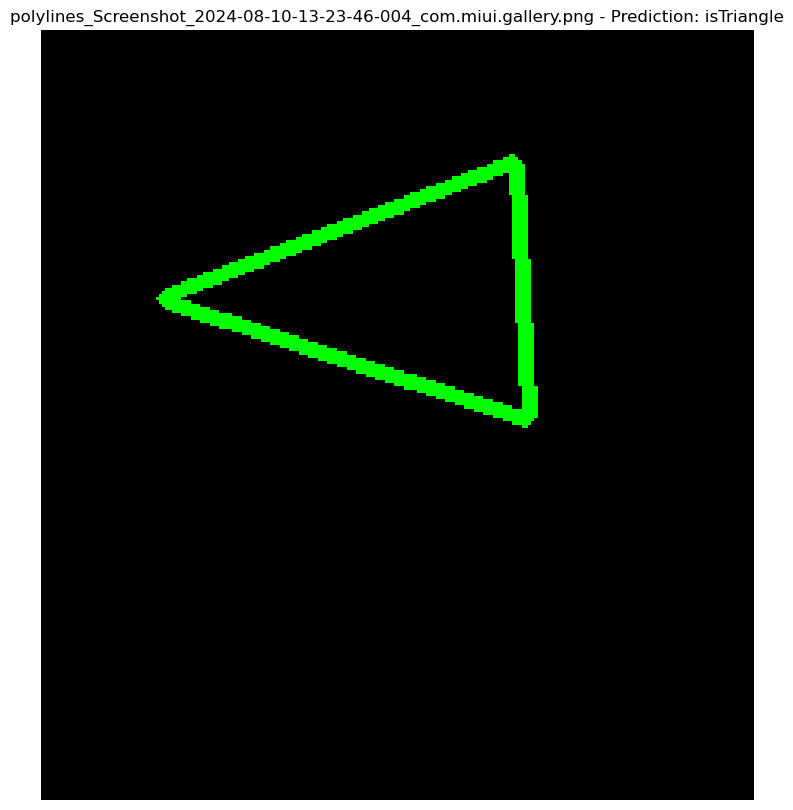

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


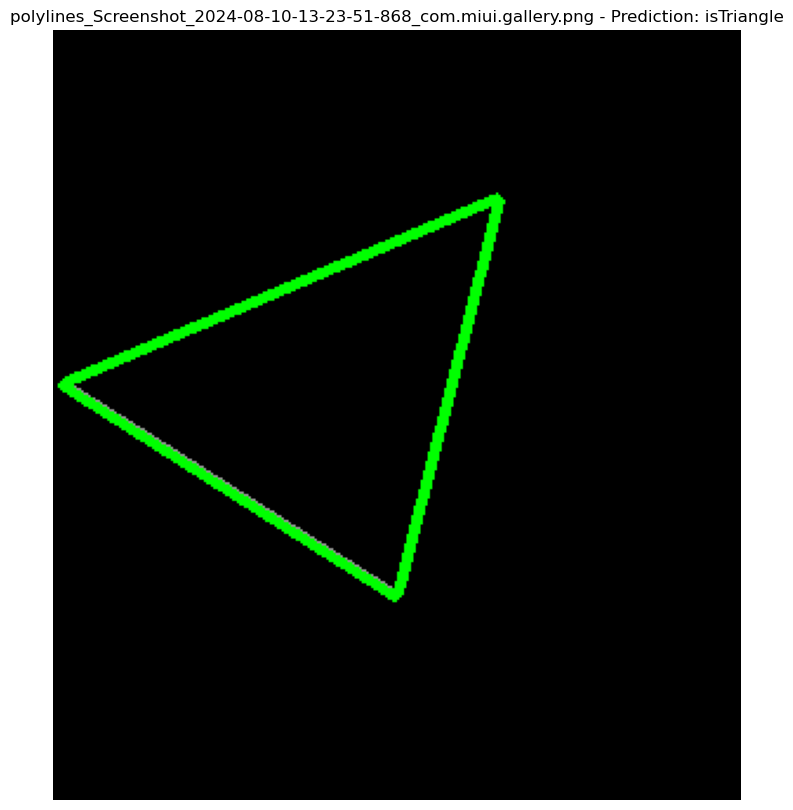

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


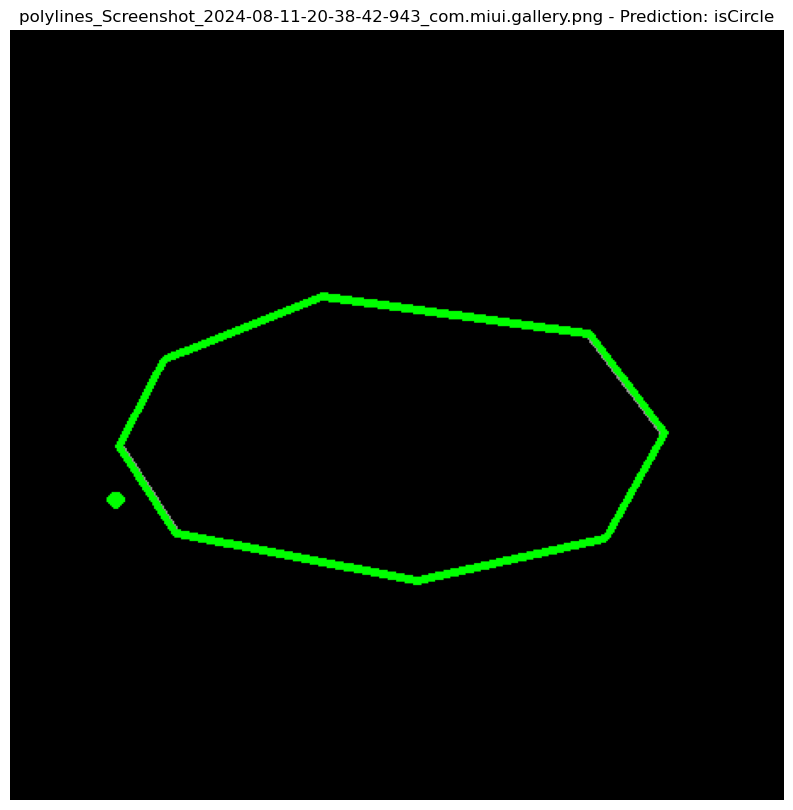

padded_contour shape: (1, 10, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


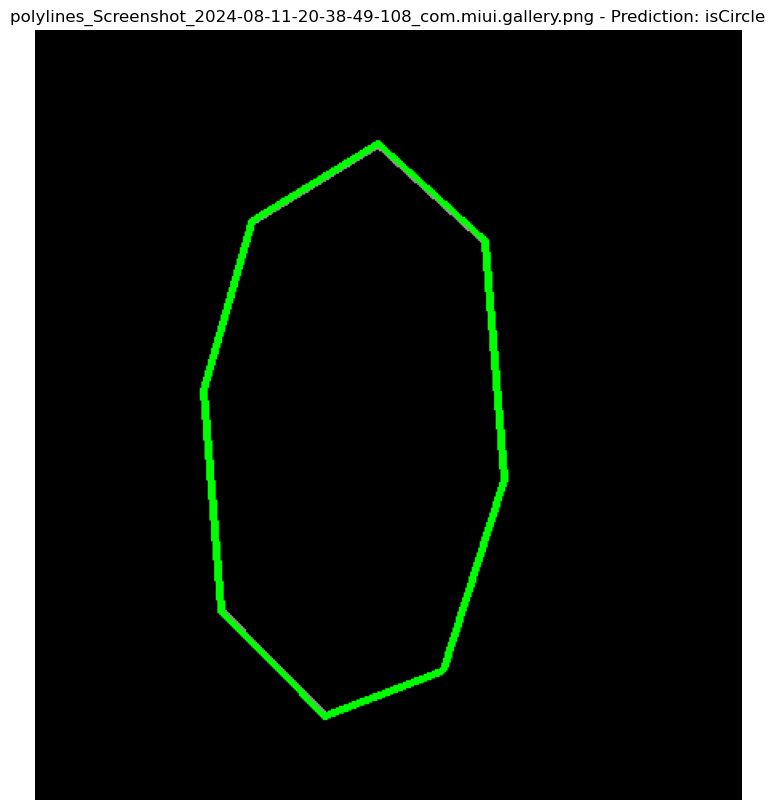

Image: polylines_Screenshot_2024-08-10-13-22-05-825_com.miui.gallery.png, Prediction: {'isCircle': 0.99999976, 'isSquare': 2.3019805e-07, 'isTriangle': 1.4059491e-09, 'isEllipse': 1.6433267e-08}
Image: polylines_Screenshot_2024-08-10-13-22-17-298_com.miui.gallery.png, Prediction: {'isCircle': 1.0, 'isSquare': 1.6151694e-09, 'isTriangle': 2.181939e-12, 'isEllipse': 2.837839e-12}
Image: polylines_Screenshot_2024-08-10-13-22-24-766_com.miui.gallery.png, Prediction: {'isCircle': 1.0, 'isSquare': 3.327712e-09, 'isTriangle': 5.173772e-12, 'isEllipse': 3.6558468e-11}
Image: polylines_Screenshot_2024-08-10-13-22-35-860_com.miui.gallery.png, Prediction: {'isCircle': 0.966299, 'isSquare': 0.0004378934, 'isTriangle': 3.5872257e-05, 'isEllipse': 0.033227205}
Image: polylines_Screenshot_2024-08-10-13-22-44-071_com.miui.gallery.png, Prediction: {'isCircle': 4.9658976e-08, 'isSquare': 1.0, 'isTriangle': 5.248003e-09, 'isEllipse': 5.5393065e-13}
Image: polylines_Screenshot_2024-08-10-13-22-52-526_com.

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define max_len to match the expected input length
max_len = 10  # Adjust this value as needed based on your model

def vectorize_image(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold the image to binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours in the image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Approximate the contour with fewer points
    vectorized_contour = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vectorized_contour.append(approx)
    
    # Flatten and pad contour data
    flattened_contour = np.array([point.flatten() for contour in vectorized_contour for point in contour])
    flattened_contour = np.array(flattened_contour)  # Convert to numpy array
    if flattened_contour.size == 0:
        flattened_contour = np.zeros((max_len, 2))  # Adjust size if no contours found
    padded_contour = pad_sequences([flattened_contour], maxlen=max_len, padding='post', dtype='float32')

    # Ensure 2 channels
    if padded_contour.shape[-1] == 1:
        padded_contour = np.concatenate([padded_contour, np.zeros_like(padded_contour)], axis=-1)

    # Check the shape of the padded_contour
    print(f'padded_contour shape: {padded_contour.shape}')
    
    return padded_contour, image, contours

def predict_shape(image_path, model):
    # Vectorize the input image
    padded_contour, original_image, contours = vectorize_image(image_path)
    
    # Reshape for the model
    if len(padded_contour.shape) == 3 and padded_contour.shape[1] == max_len and padded_contour.shape[2] == 2:
        padded_contour = padded_contour.reshape(1, max_len, 2)  # Ensure correct shape
    else:
        raise ValueError(f'Unexpected shape for padded_contour: {padded_contour.shape}')

    # Make predictions
    predictions = model.predict(padded_contour)
    
    # Interpret predictions
    labels = ['isCircle', 'isSquare', 'isTriangle', 'isEllipse']
    prediction_dict = dict(zip(labels, predictions[0]))
    
    return prediction_dict, original_image, contours

def visualize_image_and_prediction(image, contours, prediction, title=''):
    # Convert image to RGB for visualization if it is grayscale
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Draw contours on the image with a thicker line and color
    image_with_contours = cv2.drawContours(image_rgb.copy(), contours, -1, (0, 255, 0), 3)
    
    # Display image with contours and prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_contours)
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_directory(directory_path, model):
    predictions = {}
    for filename in os.listdir(directory_path):
        if filename.lower().endswith('.png'):
            image_path = os.path.join(directory_path, filename)
            try:
                prediction, original_image, contours = predict_shape(image_path, model)
                predictions[filename] = prediction
                # Visualize the image with contours and prediction
                title = f"{filename} - Prediction: {max(prediction, key=prediction.get)}"
                visualize_image_and_prediction(original_image, contours, prediction, title)
            except Exception as e:
                print(f'Error processing {filename}: {e}')
    return predictions

# Example usage
directory_path = "F://Adobe-GenSolve//Dataset//Testing//Polyline-Hand-Drawn-Shapes"
predictions = process_directory(directory_path, cnn_model)

# Print the predictions
for image_name, prediction in predictions.items():
    print(f'Image: {image_name}, Prediction: {prediction}')
